In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network applied on preselected feautre space from HCMC reutnred from feature selection, target variabels to predict are the relative commercial content losses [fraction of content loss to total content value ] of shophouses and the relative losses due to business interurption [% reduction during the flood, relative to monthly sales]

BN package: https://github.com/mike-mendoza/py_banshee

In [2]:
import sys, os
import logging
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import mpl_scatter_density # adds projection="scatter_density"
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


OUTPATH_UTILS = os.path.join(os.path.abspath(""), "../", "utils")
# OUTPATH_UTILS = os.path.join(os.path.abspath(""), s.OUTPATH_UTILS)
sys.path.append(OUTPATH_UTILS)
import settings as s
import figures as f
import evaluation_utils as eu

seed = s.seed
pd.set_option("display.max_columns", None)
#plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings("ignore")

targets = [("degree of rcloss", "degree of rcloss"), ("rbred","rbred")]
target, target_plot = targets[1]
pred_target = f"pred_{target}"


# ## save models and their evaluation in following folders:
OUTPATH_BN = Path( s.OUTPATH_BN, "businessreduction") # OUTPATH_BN.mkdir(parents=True, exist_ok=True)
OUTPATH_FEATURES = Path(s.OUTPATH_FEATURES , "rbred")
OUTPATH_ESTIMATOR = Path(s.OUTPATH_ESTIMATOR, "chance_of_loss")
OUTPATH_FIGURES = Path(s.OUTPATH_FIGURES, "bayesian_network")

# Define name of output figure with BN; used by bn_visualize
fig_name = f"bn_{target}"


c:\Anaconda\envs\py396_c3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
## load predictors set and addtional features from feature selection for BN (HCMC, rbred)
df_hcmc_org = pd.read_excel(OUTPATH_FEATURES / f"final_predictors_rbred.xlsx") #f"final_predictors_rbred_income_cv.xlsx")

##  use nice feature names
df_hcmc_org.rename(columns=s.feature_names_plot, inplace=True) 


df_hcmc_org.reset_index(drop=True, inplace=True)  # better for merging different sources, when indexes are all the same

## remove geometry and other features which are just needed for analysis
df_hcmc = df_hcmc_org.drop("geometry", axis=1)

print(df_hcmc.shape)
df_hcmc.tail(2)


(361, 18)


,rbred,emergency measures,water depth inside,resilience,no. employees,building age,mthly. income,inundation duration,non-structural measures,contaminations,structural measures,mthly. sales,flood experience,building area,flow velocity,shp_business_limitation,shp_content_value_euro,shp_sector
359,10,0.500000,70.0,1.0,1,25.0,110.5,5.0,0.75,1,0.0,276.2,151,80.0,0.1,0.0,NaN,1.0
360,0,0.333333,100.0,0.0,2,5.0,18.4,3.0,0.25,1,0.0,736.5,36,33.0,0.1,0.0,NaN,1.0


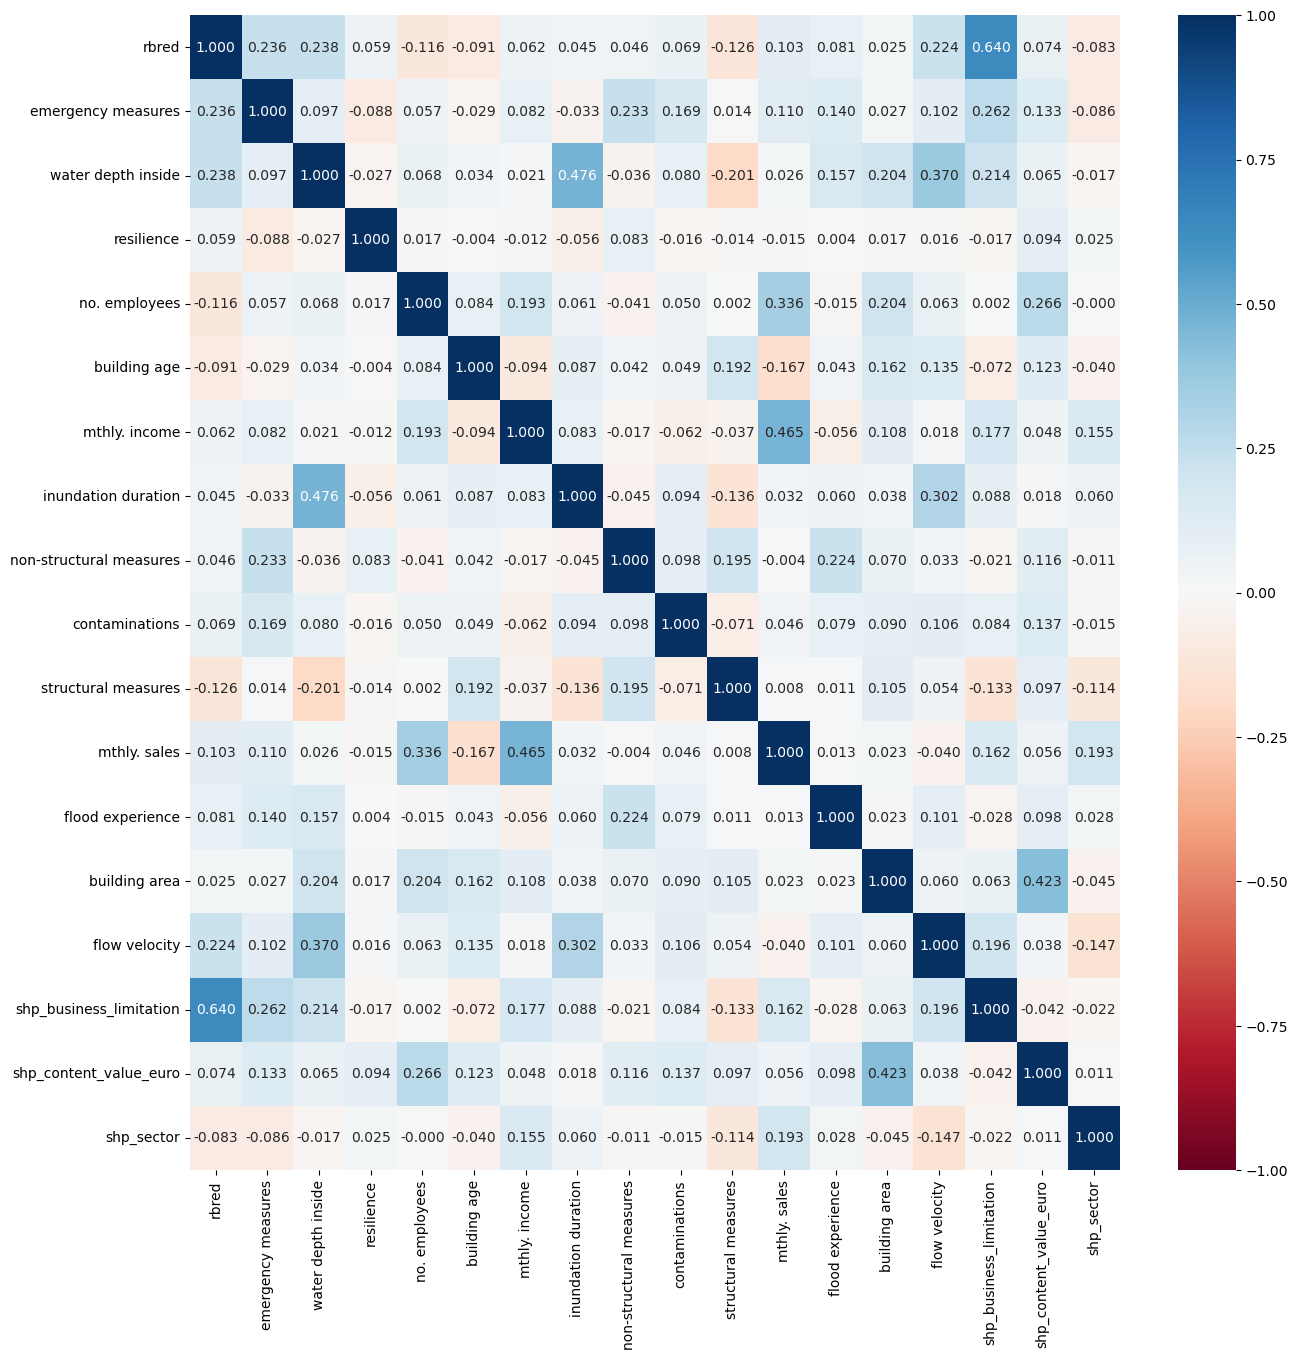

In [4]:
## find predictor with highest unconditional correlation to target
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df_hcmc.corr(method="spearman"), 
                      vmin=-1, vmax=1, 
                      annot=True, fmt=".3f", 
                      cmap="RdBu")


--> water depth  and emergency measures has strongest unconditonal correlation with rbred

## Construct BN

In [5]:

# Define the variable names
names_list = ["rbred",  'water depth inside', 'no. employees', "flow velocity",  
              "structural measures",
              ]
print(df_hcmc.columns)


# # Select the columns to use in the NPBN
df_hcmc_bn = df_hcmc[names_list]

names = {k: i for i, k in enumerate(names_list)}

print("Using following features:\n", names)

Index(['rbred', 'emergency measures', 'water depth inside', 'resilience',
       'no. employees', 'building age', 'mthly. income', 'inundation duration',
       'non-structural measures', 'contaminations', 'structural measures',
       'mthly. sales', 'flood experience', 'building area', 'flow velocity',
       'shp_business_limitation', 'shp_content_value_euro', 'shp_sector'],
      dtype='object')
Using following features:
 {'rbred': 0, 'water depth inside': 1, 'no. employees': 2, 'flow velocity': 3, 'structural measures': 4}


In [6]:
# Extract number of nodes from df_hcmc
N = df_hcmc_bn.shape[1]  # number of nodes == number of features + target
print(N)

# Defining the structure of the BN
parent_cell = [None]*N
parent_cell[0] = [1, 2, 3, 4]                                               #   target (parents: all other features)
parent_cell[1] = [3, 4]                                                     # wd
parent_cell[2] = []                                                         # employee
parent_cell[3] = []                                                         # fv 
parent_cell[4] = []                                                         # struct. m 


parent_cell

5


[[1, 2, 3, 4], [3, 4], [], [], []]

<Figure size 500x500 with 0 Axes>

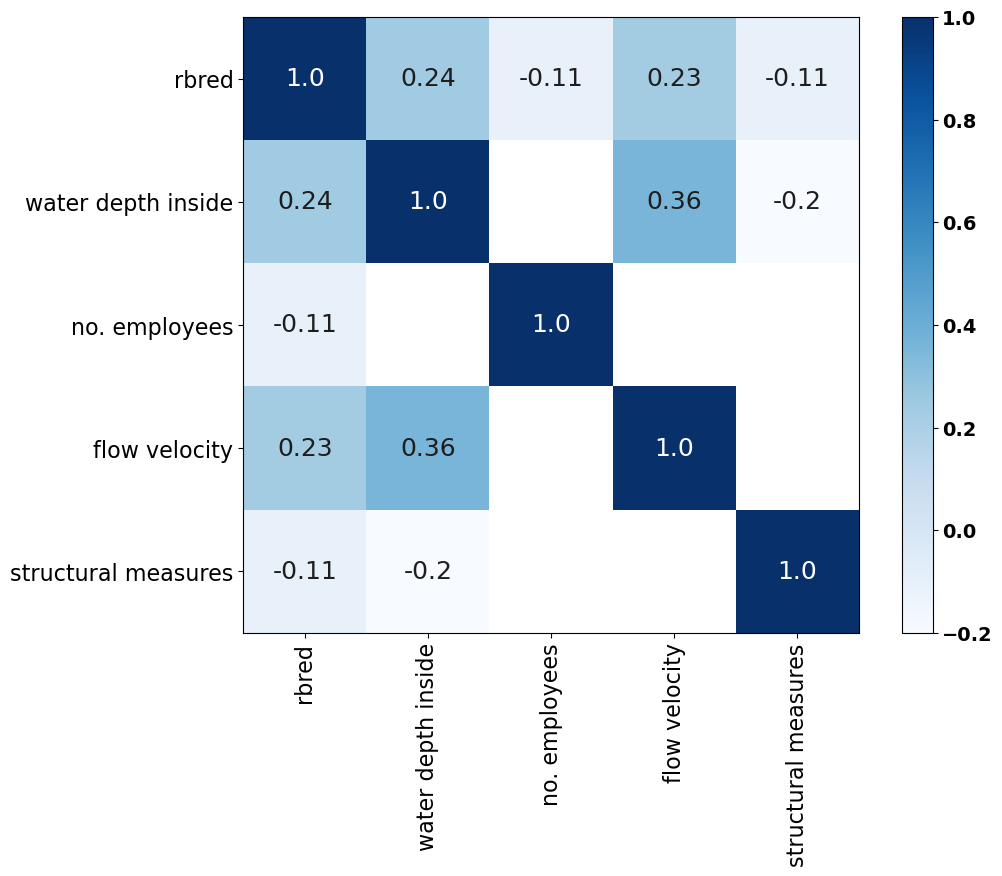

In [7]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

plt.figure(figsize=(5,5))
R = bn_rankcorr(parent_cell,        # structure of the BN
                df_hcmc_bn,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don"t create plot)

### Cross validate BN

In [8]:
condition=[1, 2, 3, 4]
num_folds = 5
testset_size = int(len(df_hcmc_bn)/num_folds  // 1)


bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
residuals_hcmc = pd.DataFrame()


for i in range(num_folds):
    
    # ## split Fold into train and test
    test_nth_fold = df_hcmc_bn[i*testset_size:][:testset_size] # 20% test
    train_nth_fold = df_hcmc_bn[ ~df_hcmc_bn.index.isin(test_nth_fold.index)] # 80% train
    print(df_hcmc_bn.shape , train_nth_fold.shape, test_nth_fold.shape)

    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # BN get rank correlations per fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,  
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  
    # B make infernece on uncondtionalized node (target)
    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix form train
                test_nth_fold,
                SampleSize=1000, 
                Output="mean")    # type of output data
 
    ## predict target
    y_pred = F_test_nth_fold.squeeze()

    # Fill out the column(s) which are predicted
    y_true = test_nth_fold.iloc[:,0].to_numpy()

    ## store for plotting obs ~ pred
    residuals_per_fold = pd.concat([pd.Series(y_true), pd.Series(y_pred).astype(int)], axis=1)
    residuals_hcmc = pd.concat([residuals_hcmc, residuals_per_fold], axis=0)

    # evaluation metrics
    MAE = eu.mean_absolute_error(y_true, y_pred)
    MBE = eu.mean_bias_error(y_true, y_pred)
    RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    print(f"Scores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    #print(f"Inference - Uncertainty distribution, for fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())


residuals_hcmc.columns = ["y_true", "y_pred"]

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = OUTPATH_BN / f"bn_performance_{target}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"\nAveraged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = OUTPATH_BN / f"bn_avg_performance_{target}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)



eu.empirical_vs_predicted(residuals_hcmc["y_true"], residuals_hcmc["y_pred"])


(361, 5) (289, 5) (72, 5)
Scores from fold 0: 14.999593055555557 0.7015208333333333 20.425075778375 68.68763731700065
(361, 5) (289, 5) (72, 5)
Scores from fold 1: 18.731088888888888 0.15898333333333367 23.677153159621337 68.90544864810458
(361, 5) (289, 5) (72, 5)
Scores from fold 2: 18.42372777777778 -0.8277222222222227 23.820849327287497 57.14496069729515
(361, 5) (289, 5) (72, 5)
Scores from fold 3: 16.565875 1.2486388888888895 22.118843393762198 58.18321416705807
(361, 5) (289, 5) (72, 5)
Scores from fold 4: 24.574093055555554 -0.28687638888888983 32.034860794910685 56.42915636364039

Averaged evaluation scores of k-fold cross-validation (mean) :
          MAE       MBE       RMSE      SMAPE
0  18.658876  0.198909  24.415356  61.870083 
..saved to ..\model_results\bayesian_network\businessreduction\bn_performance_rbred_hcmc.xlsx


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,360,10.0,18.516667,"[0, 100]",637.26,25.21,136.331152
predicted,360,17.0,18.169444,"[4, 100]",74.42,8.61,47.479074


#### get uncertainties in rbred predictions

In [9]:
condition = condition 
values = df_hcmc_bn.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_hcmc_bn,        # DataFrame for cantho
              SampleSize=1000, 
              Interp='next',
              Output="full")    # type of output data


# print("Inference - Uncertainty distribution: ", pd.Series(F()).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_hcmc_bn.iloc[:,0].to_numpy()



In [10]:
y_pred.shape

(361, 1000)

In [11]:

### avg. uncertainties
dict = {}

for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample


df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: samples or flood cases, rows: sample number 
df_uncertainties.tail(10)


# get mean of uncertainty distbution for each flood case
df_uncertainties_avg = df_uncertainties

df_uncertainties_p = pd.DataFrame()
df_uncertainties_p["avg_modelled"] = df_uncertainties_avg.mean(axis=0)
df_uncertainties_p["observed"] = y_true
df_uncertainties_p["city"] = "HCMC"

df_uncertainties_p

# import folium
# map = folium.Map(location=[106.6637,10.6878], default_zoom_start=15)


,avg_modelled,observed,city
0,13.2593,0,HCMC
1,16.1688,0,HCMC
2,8.8827,0,HCMC
3,11.7655,0,HCMC
4,9.5583,0,HCMC
...,...,...,...
356,20.6582,30,HCMC
357,16.0746,30,HCMC
358,20.0901,10,HCMC
359,16.5011,10,HCMC


#### BN visualize

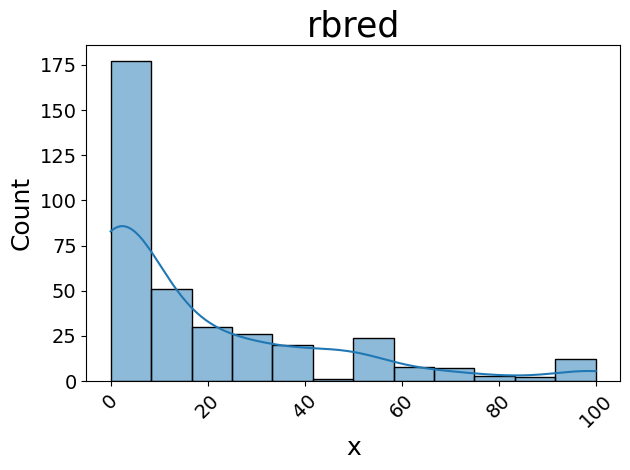

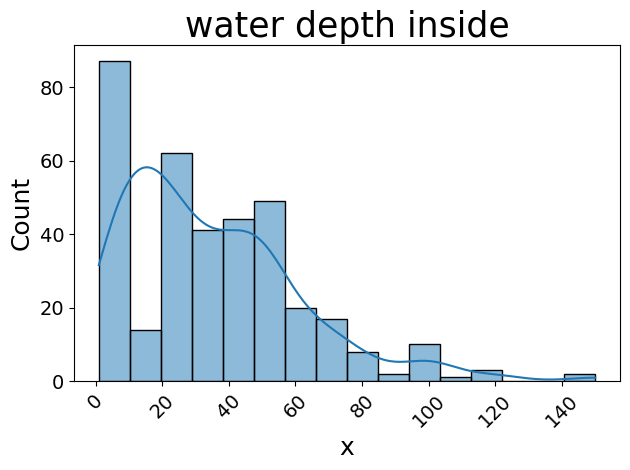

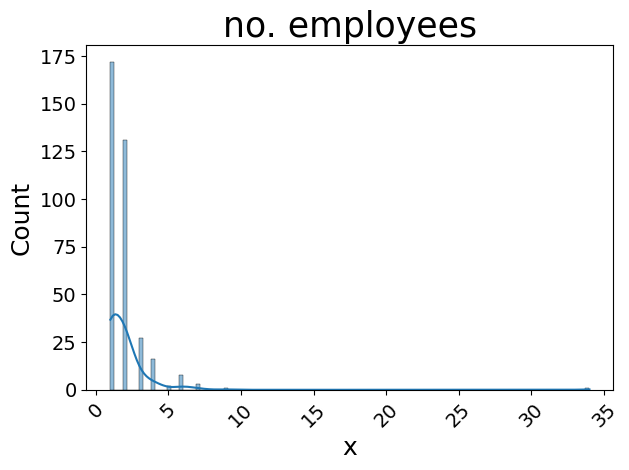

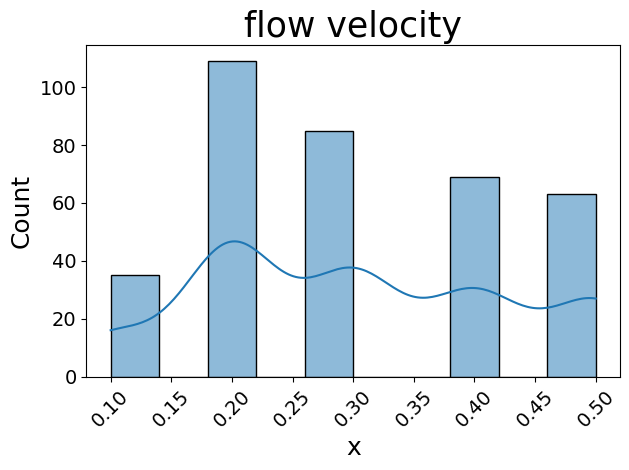

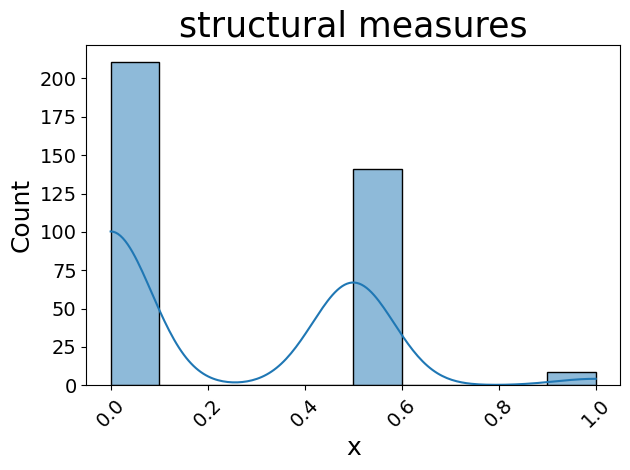

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\bayesian_networks\\BN_visualize_bn_structure_rbred_margins.pdf'

In [12]:
# '# #-----------------------------------------------------------------------------
# Function 2 - bn_visualize - Plot of the Bayesian Network
#-----------------------------------------------------------------------------

##  BN structure with graph + rank correlations on all b.reduction samples

## TODO change pybanhsee package for figure: make outpath adding possible (maybe rm prefix "BN_visualize_")
fig_name =  f"bn_structure_{target}"

df_hcmc_bn_plot = df_hcmc_bn # .rename(

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             df_hcmc_bn_plot.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with x nodes and x arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             df_hcmc_bn_plot.columns,                      # names of variables
             data = df_hcmc_bn_plot,                       # DataFrame with data
             fig_name = fig_name + '_margins')  # figure name




## Copula test

<Figure size 2000x1500 with 0 Axes>

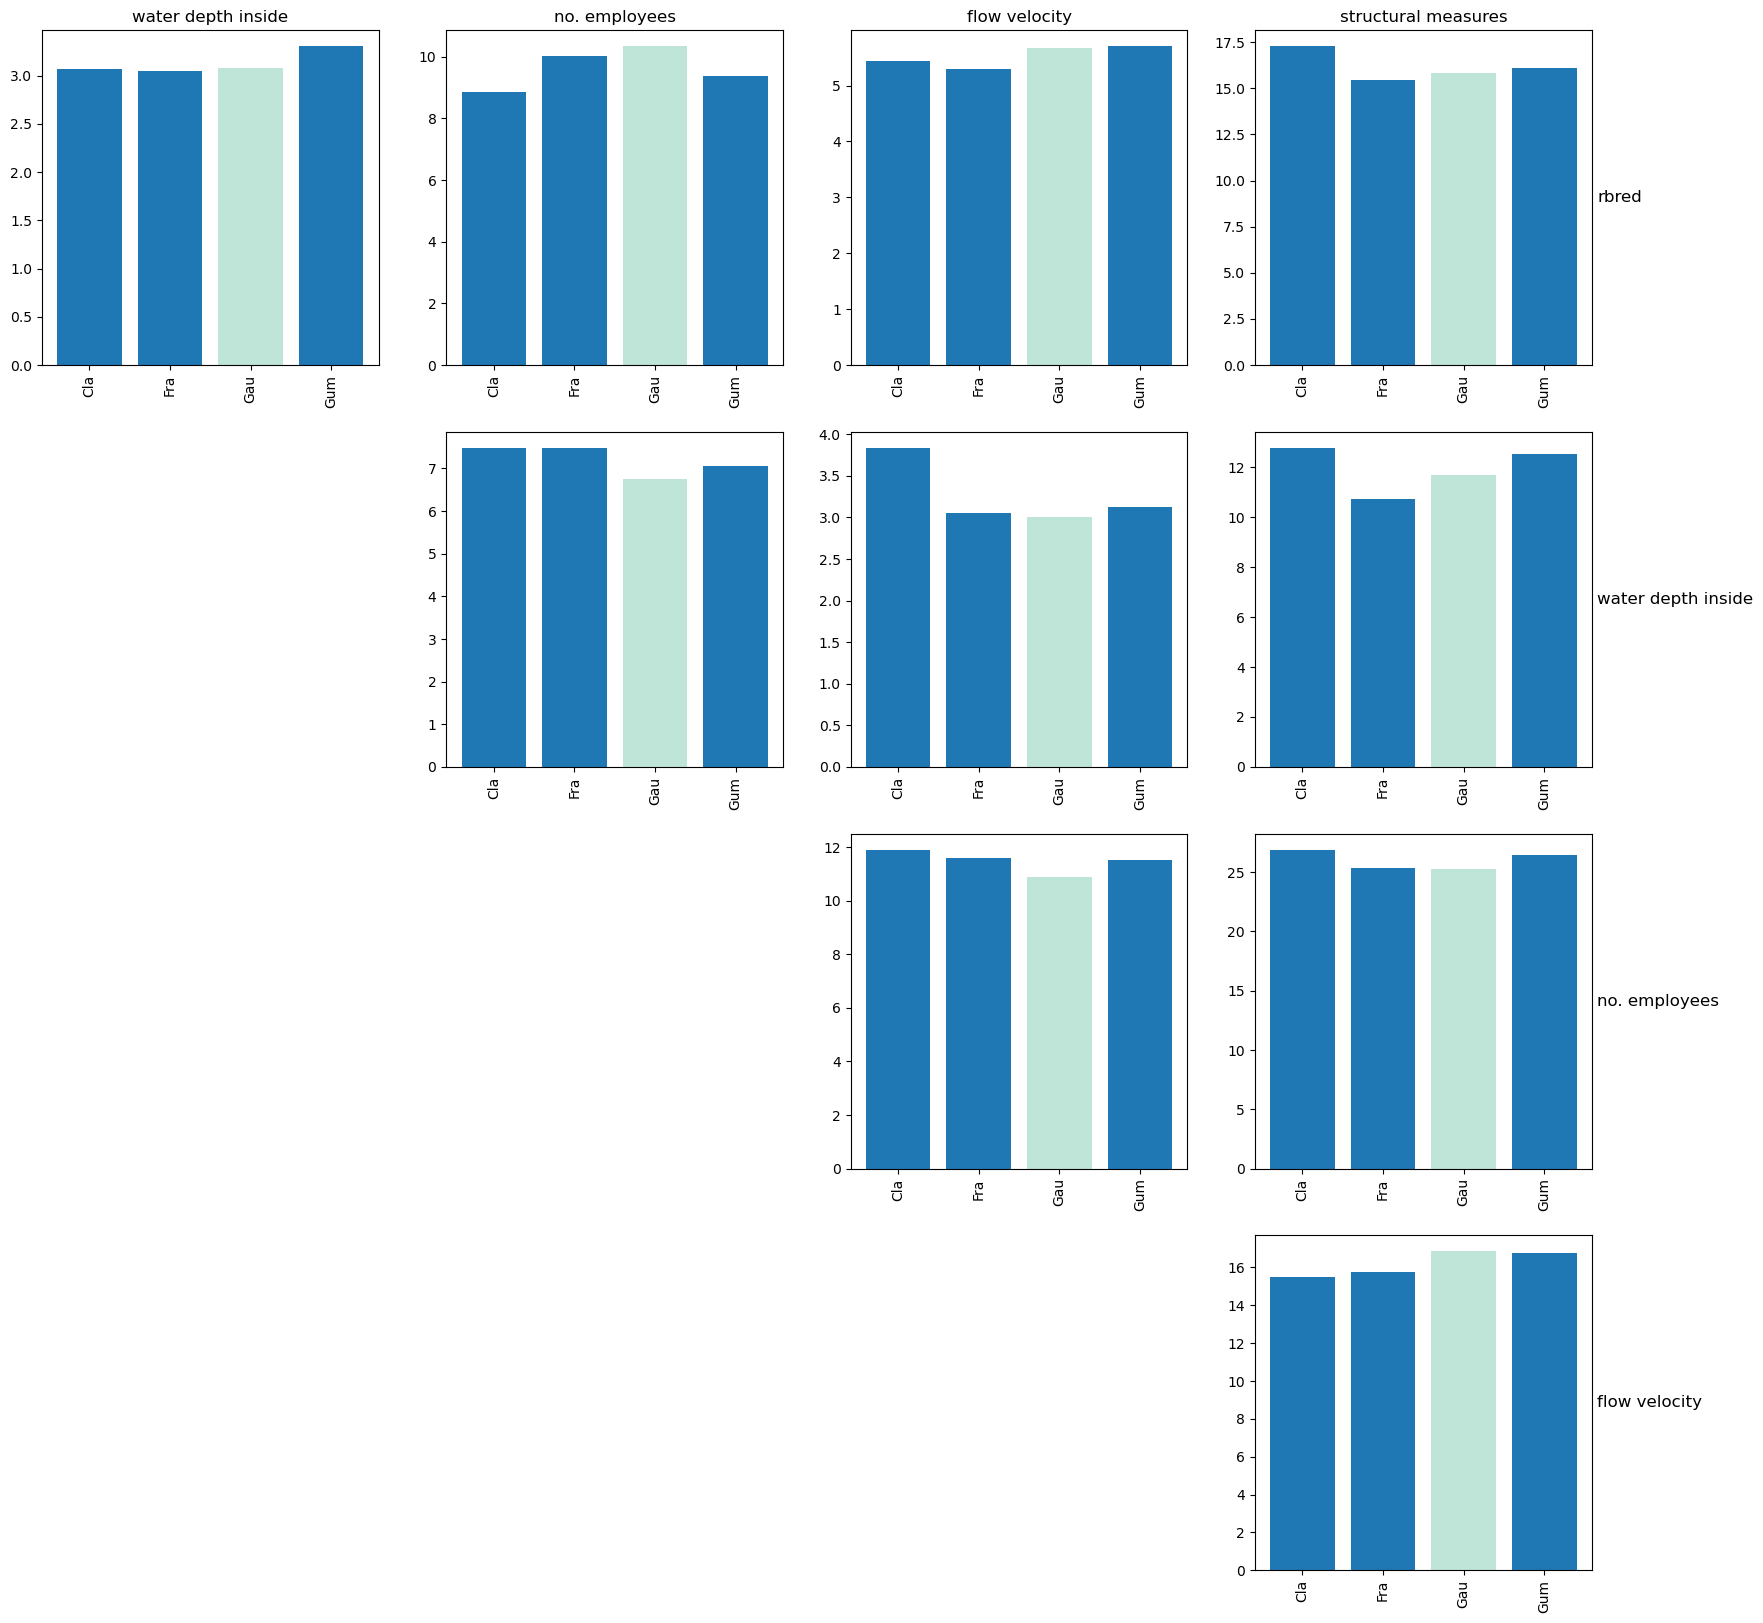

In [13]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

plt.figure(figsize=(20,15))
M = cvm_statistic(df_hcmc_bn,                   # df_predictorsFrame with df_hcmc
                  names = df_hcmc_bn.columns,   # names of variables
                  plot = True,               # create a plot (0=don"t create plot)
                  fig_name = "empricial_corpula_all vars_rbred")    # figure name
                  
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.



##### d-calibration score

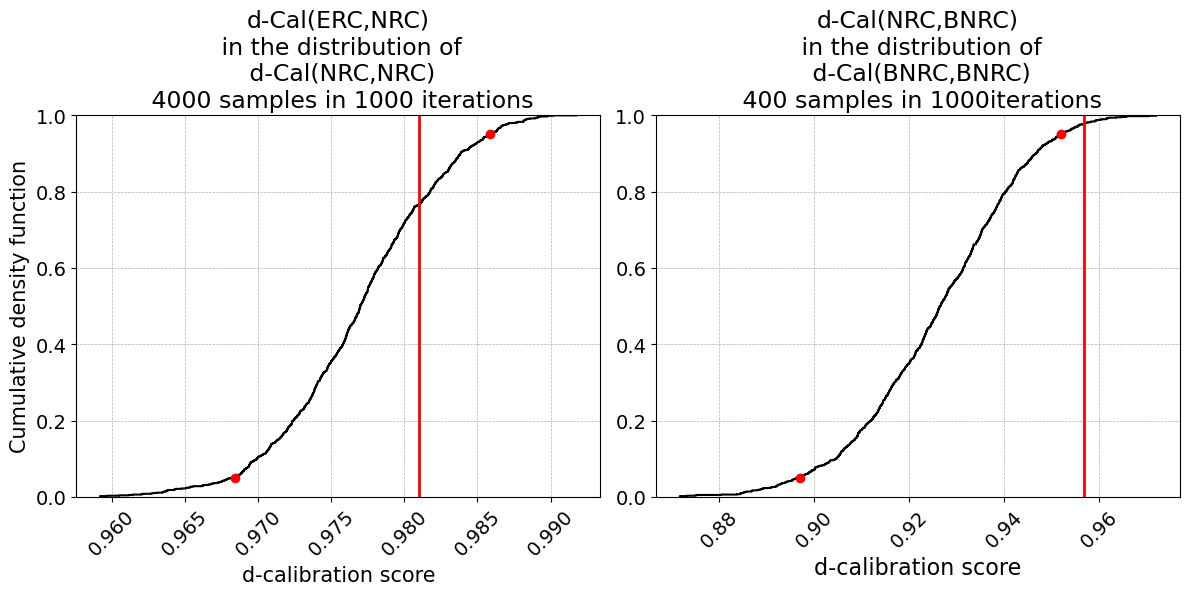

SUCCESS: The d-Cal of the empirical rank correlation matrix (ERC) fall between the confidence intervals of the d-Cal of the normal rank correlation matrix (NRC)

FAILURE: The d-Cal of the normal rank correlation matrix (NRC) is out of the confidence intervals of the d-Cal of the BN rank correlation matrix (BNRC)



In [14]:
# -----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
# -----------------------------------------------------------------------------


# gaussian_distance : validation: 
D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
                            R,        # the rank correlation matrix 
                            df_hcmc_bn,     # df_predictorsFrame with df_hcmc
                            4000,     # number of samples drawn d-Cal(ERC,NRC)
                            400,      # number of samples drawn d-Cal(NRC,BNRC)
                            1000,     # number of iterations to compute CI
                            Plot=True,          # create a plot (0=don"t create plot)
                            Type="H",           # take Hellinger distance (default)
                            fig_name=fig_name)  # figure name

                        
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the BN"s rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large df_predictor sets.


## Evaluation: HCMC


In [15]:
## add binary dummy var for plotting zero-damage vs damage cases
residuals_hcmc["binary_true_dummy"] = 0
idx_damage = np.where(residuals_hcmc["y_true"] >= 1)[0]
residuals_hcmc["binary_true_dummy"].iloc[idx_damage] = 1


## add residuals
residuals_hcmc["residual"] = residuals_hcmc["y_pred"] - residuals_hcmc["y_true"]

### plot obs ~ pred

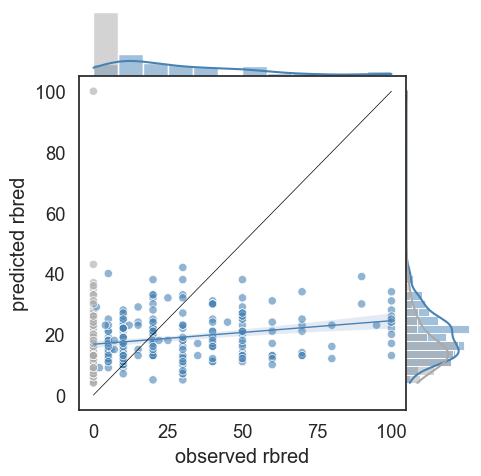

In [16]:
f.plot_observed_predicted(
    residuals_hcmc["y_true"], residuals_hcmc["y_pred"],  
    hue=residuals_hcmc["binary_true_dummy"], 
    hue_colors=("darkgrey","steelblue"), # if differentiation: set both time the same color
    xlabel=f"observed {target_plot}", ylabel=f"predicted {target_plot}",
    legend=False, #True
    outfile= OUTPATH_FIGURES / f"scatter_obs_pred_{target_plot}_hcmc.png"
)   

### Main validation results

In [17]:
## get ratio of damage cases vs total reported bred

c = "y_pred"
print(len(np.where(residuals_hcmc[c] > 0.0)[0])) 
print(len(np.where(residuals_hcmc[c] > 0.0)[0]) / len(residuals_hcmc[c]) * 100, "%")
np.mean(residuals_hcmc[c])


360
100.0 %


18.169444444444444

#### Plot residuals

In [18]:
from matplotlib.colors import to_rgba

def plot_residuals_single(x, y, hue_group):

    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)

    hue_colors=("darkgrey","steelblue")
    alpha=0.7

    color_dict = {
        0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
        1: to_rgba(hue_colors[1], alpha)
    }
    ax.axhline(0, ls='--')
    sns.scatterplot(
        x = x, 
        y = y, # pred - obs 
        hue = hue_group,
        #color = "steelblue",
        alpha = 0.5,
        #hue=df_hcmc_abred["abs_bred_true_dummy"]
        palette=color_dict, edgecolors=color_dict
    )
    plt.xlabel("observation")
    plt.ylabel("residuals (prediction - observation)")


**test residuals grouped by sales / sector**

In [19]:
df_hcmc.describe()


,rbred,emergency measures,water depth inside,resilience,no. employees,building age,mthly. income,inundation duration,non-structural measures,contaminations,structural measures,mthly. sales,flood experience,building area,flow velocity,shp_business_limitation,shp_content_value_euro,shp_sector
count,361.000000,361.000000,360.000000,361.000000,361.000000,338.000000,343.000000,354.000000,361.000000,361.000000,361.000000,361.000000,361.000000,359.000000,361.000000,361.000000,309.000000,346.000000
mean,18.465374,0.410434,34.855556,2.587258,1.941828,19.804734,436.435277,11.499153,0.359418,0.991690,0.220222,372.094737,81.764543,88.795265,0.304432,5.277008,4132.808414,1.306358
std,25.227730,0.263193,26.518217,1.049969,2.078847,14.201926,396.631478,29.298343,0.296638,0.390779,0.272552,455.947443,53.496910,99.076251,0.125752,21.537938,4566.198011,0.578669
min,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,18.400000,0.200000,0.000000,0.000000,0.000000,92.100000,3.000000,12.000000,0.100000,0.000000,257.800000,1.000000
25%,0.000000,0.166667,15.000000,1.750000,1.000000,11.000000,294.600000,2.000000,0.250000,1.000000,0.000000,92.100000,36.000000,42.000000,0.200000,0.000000,1841.300000,1.000000
50%,10.000000,0.500000,30.000000,2.500000,2.000000,18.000000,294.600000,3.000000,0.250000,1.000000,0.000000,276.200000,76.000000,75.000000,0.300000,0.000000,3203.800000,1.000000
75%,30.000000,0.666667,50.000000,3.500000,2.000000,24.000000,552.400000,6.000000,0.500000,1.000000,0.500000,276.200000,151.000000,100.000000,0.400000,3.000000,4603.200000,1.000000
max,100.000000,1.000000,150.000000,5.000000,34.000000,100.000000,3314.300000,240.000000,1.000000,2.000000,1.000000,2761.900000,151.000000,1000.000000,0.500000,365.000000,50635.200000,3.000000


(360, 4)
(163, 4)


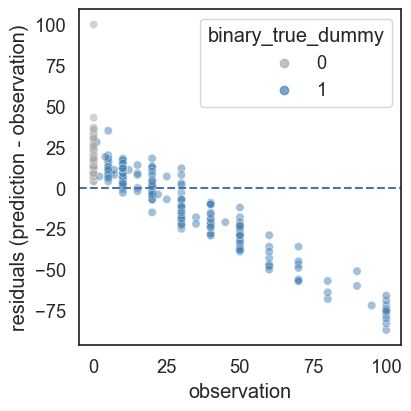

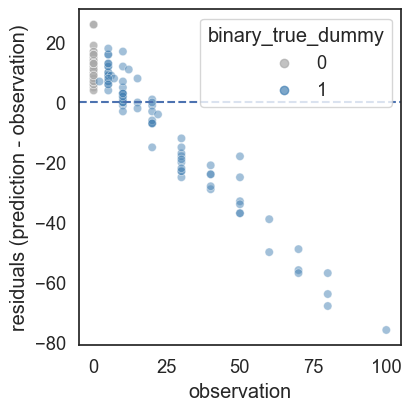

In [20]:
print(residuals_hcmc.shape)
plot_residuals_single(residuals_hcmc["y_true"], residuals_hcmc["residual"], residuals_hcmc["binary_true_dummy"],)

# idx = df_hcmc.loc[df_hcmc["mthly. sales"]>300, :].index
# idx = df_hcmc.loc[df_hcmc["water depth inside"] < 30, :].index
idx = df_hcmc.loc[df_hcmc["water depth inside"] < 30, :].index

residuals_hcmc_subset = residuals_hcmc.iloc[idx, :]

print(residuals_hcmc_subset.shape)
plot_residuals_single(residuals_hcmc_subset["y_true"], residuals_hcmc_subset["residual"], residuals_hcmc_subset["binary_true_dummy"],)

## tested groups
## --> sales: no pattern of over/underestimation tendency visual visible for sale groups
## --> wd: when wd > 30m and sm losses occured than they are rather predictedoverestiated by the model (compared to residuals based on all samples)
##      wd < 30 and small losses are predicted with smaller overestimation bias

### Absolute business reduction

**NOTE !**
- P1Q5.5.9 to rbred: How strongly was your monthly sale/ production reduced during the flood? (%-reduction)
- P1Q5.5.8 to blim: How long did it take for your business to get back to normal daily trading / production (days)
-> abs. bred just represents the losses occured during the flood but not for the month (~30 days), \\
thus: \\
**abs_bred = (rbred * sales * blim) / (30*100)**


In [21]:
## TODO fix workaround that each record is used once for validation, currently 356 records and with 5 folds one sample has to been drop 
df_hcmc = df_hcmc[:-1]  # drop last record which is not caputred by cross-vladiation folds 

assert all(df_hcmc[target].tail(29).values ==  residuals_hcmc["y_true"].tail(29).values),  "fix code were y_true is shuffled - residual df should have the same order as when it was loaded"


In [22]:

##  get first abs loss of only damage cases (only BN results) due that rcloss cases are all multiplied by chance of loss
df_hcmc_abred = df_hcmc_bn.copy()


## calc probability obs. abs bred
df_hcmc_abred["abred"] = np.nan
# df_hcmc_abred["abred"] = df_hcmc_abred[target] * df_hcmc["mthly. sales"] / 100
df_hcmc_abred = df_hcmc.assign(abred = lambda x: (x[target] * x["mthly. sales"] * x["shp_business_limitation"]) / (30*100))

## make sure that order of records is identical between BN predictions and osberved rbred
assert all(df_hcmc_abred["rbred"].reset_index(drop=True) == residuals_hcmc.y_true.reset_index(drop=True))

## calc probability pred. abs bred
df_hcmc_abred["pred_abred"] = np.nan
df_hcmc_abred["pred_rbred"] = residuals_hcmc["y_pred"].reset_index(drop=True)
df_hcmc_abred = df_hcmc_abred.assign(pred_abred = lambda x: (residuals_hcmc["y_pred"].reset_index(drop=True) * x["mthly. sales"].reset_index(drop=True) * x["shp_business_limitation"].reset_index(drop=True)) / (30*100))
# df_hcmc_abred["abred_pred"] = residuals_hcmc["y_pred"].reset_index(drop=True) *  df_hcmc["mthly. sales"].reset_index(drop=True)  / 100 
# df_hcmc_abred["abred_pred"] = df_hcmc_abred[pred_target] *  df_hcmc_abred["mthly. sales"] / 100 


## add binary dummy var for plotting zero-damage vs damage cases
df_hcmc_abred["binary_true_dummy"] = 0
idx_damage = np.where(residuals_hcmc["y_true"] >= 1)[0]
df_hcmc_abred.loc[idx_damage, "binary_true_dummy"] = 1
#df_hcmc_abred.describe()


## rm mising obsvation
df_hcmc_abred.dropna(inplace=True)

print("HCMC : absolute business interruption (zero-cases and damage cases)")
eu.empirical_vs_predicted(df_hcmc_abred["abred"], df_hcmc_abred["pred_abred"])


HCMC : absolute business interruption (zero-cases and damage cases)


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,269,0.0,31.386617,"[0, 736]",12081.33,109.71,350.197322
predicted,269,0.0,13.237918,"[0, 397]",1747.24,41.72,315.759771


Notes to abs loss
- obs. and pred. mean are quite similar, underestimate higher losses as seen in higher median of predictions

**plot abs bred**

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from matplotlib.cbook import boxplot_stats  
from matplotlib.colors import to_rgba

def plot_observed_predicted_abs(y_true, y_pred, hue=None, hue_colors=("darkgrey","steelblue"), xlabel="observed", ylabel="predicted", target=None, alpha=0.6, legend=False, outfile="test.png"):
    """
    Scatter plot of observations vs predictions with optional class colors
    NOTE: hue is currently limited to binary cases
    # Code Snippet: https://stackoverflow.com/questions/66667334/python-seaborn-alpha-by-hue
    """

    sns.set(style="white", font_scale=1.2)

    color_dict = {
        0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
        1: to_rgba(hue_colors[1], alpha)
    }
    if hue is None:
        color_dict = color_dict[1]
    
    g = sns.JointGrid(
        x=y_true, y=y_pred, hue=hue,
        height=5, space=0,)
    # g.plot_joint(sns.scatterplot, palette=color_dict, edgecolors=color_dict, legend=legend)
    p = sns.scatterplot(
        x=y_true, y=y_pred, hue=hue, 
        palette=color_dict, edgecolors=color_dict, legend=legend, 
        ax=g.ax_joint)
    
    if legend is True:
        #p.legend(fontsize=10, )  # outside plot: bbox_to_anchor= (1.2,1)
        plt.setp(p.get_legend().get_texts(), fontsize='12')  
        plt.setp(p.get_legend().get_title(), fontsize='15')

    g.plot_marginals(sns.histplot, kde=False, palette=color_dict, multiple='stack')

    g1 = sns.regplot(
        x=y_true, y=y_pred, 
        line_kws={"lw":1.},
        scatter=False, ax=g.ax_joint)
    regline = g1.get_lines()[0]
    regline.set_color('steelblue')

    x0, x1 = (0, 100) 
    y0, y1 = (0, 100)
    lims = [min(x0, y0), max(x1, y1)]
    g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    # plt.title(f"Observed and predicted {target}")


    # save plot
    plt.savefig( outfile, dpi=300, bbox_inches="tight")

    plt.show()
   # plt.close()


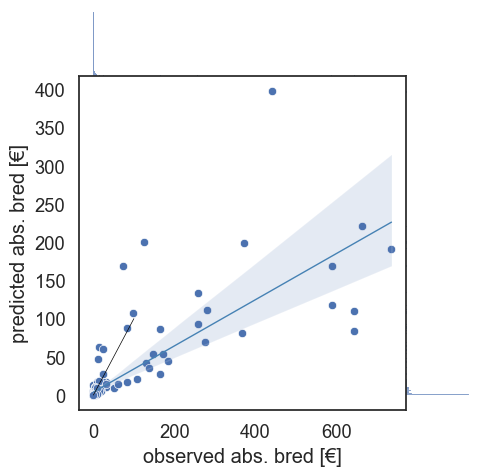

In [24]:
## TODO adapt x and y aixs to same limits -> use fixed max for xlim and ylim 
plot_observed_predicted_abs(
    y_true=df_hcmc_abred["abred"], y_pred=df_hcmc_abred["pred_abred"], 
    hue=None, #df_hcmc_abred["binary_true_dummy"],
    xlabel=f"observed abs. bred [€]", ylabel=f"predicted abs. bred [€]",  #target=target_plot,
    legend=False, #True
    outfile= OUTPATH_FIGURES / f"scatter_obs_pred_abs_bred_{target_plot}_hcmc.png"
)     


## Model transferability
Test trained NPBN for CanTHo DS

In [25]:
infile_name = "input_data_businessreduction_cantho"
df_cantho = pd.read_excel(f"../input_survey_data/{infile_name}.xlsx")

##  use nice feature names
df_cantho.rename(columns=s.feature_names_plot, inplace=True) 

## prepare CanTHo for BN - adpat with same column structure as training dataset
df_cantho_bn = df_cantho[df_hcmc_bn.columns]
 
print(df_cantho_bn.shape)
df_cantho_bn.tail(2)

(313, 5)


,rbred,water depth inside,no. employees,flow velocity,structural measures
311,50,20,4,0.3,0.666667
312,50,50,1,0.2,0.333333


### Prediction and Evaluation on CanTho Bred

Conditionalize with missing predictor for water depth, make inference of water depth and target variable, condtionalize on the three remaining predictors

In [26]:
# condition = [1, 2, 3, 4] #condition # [1, 2, 3, 4] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_cantho_bn.iloc[:, [2, 3, 4]].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference([2, 3, 4],        # nodes that will be conditionalized - sparse model
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn, #df_cantho_bn.drop("water depth inside", axis=1),        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="mean")    # type of output data
              #Output="median")    # type of output data

## inference of node for water depth and node for target
F_water = [row[0] for row in F]
F_target = [row[1] for row in F]
print("Inference - Uncertainty distribution: ", pd.Series(F_target).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F_target
y_true = df_cantho_bn.iloc[:,0].to_numpy()


# evaluation metrics
MAE = eu.mean_absolute_error(y_true, y_pred)
MBE = eu.mean_bias_error(y_true, y_pred)
RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

print(f"\nObserved and predicted target distribution for CanTho:")
eu.empirical_vs_predicted(y_true, pd.Series(y_pred))

Inference - Uncertainty distribution:  count    313.000000
mean      27.481288
std        9.302009
min        9.358000
25%       20.979700
50%       25.911000
75%       31.756300
max       80.100000
dtype: float64
MAE,: 20.93629584664537
MAE, MBE, RMSE, SMAPE: 20.93629584664537 -13.381332268370606 27.4562128535543 29.337130874117815

Observed and predicted target distribution for CanTho:


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,313,40.0,40.862620,"[0, 100]",477.46,21.82,53.473876
predicted,313,25.0,27.003195,"[9, 80]",86.76,9.30,34.494006


In [27]:
residuals_cantho_sparse = pd.DataFrame(
            {
                "y_true": pd.Series(y_true),
                "y_pred": pd.Series(y_pred),
                "residual": pd.Series(y_pred) - pd.Series(y_true),  # + residual=overestim, -residual=underestimation of model
            },
            index=pd.Series(y_true).index)

## add binary dummy var for plotting zero-damage vs damage cases
residuals_cantho_sparse.reset_index(drop=True, inplace=True)
residuals_cantho_sparse["binary_true_dummy"] = 0
idx_damage = np.where(residuals_cantho_sparse["y_true"] >= 1)[0]
residuals_cantho_sparse.loc[idx_damage, "binary_true_dummy"] = 1
residuals_cantho_sparse.describe()


print("Bred, cantho, sparse BN")
print(residuals_cantho_sparse.describe())



Bred, cantho, sparse BN
           y_true      y_pred    residual  binary_true_dummy
count  313.000000  313.000000  313.000000         313.000000
mean    40.862620   27.481288  -13.381332           0.977636
std     21.850827    9.302009   24.013035           0.148102
min      0.000000    9.358000  -87.017100           0.000000
25%     25.000000   20.979700  -25.534000           1.000000
50%     40.000000   25.911000  -12.327100           1.000000
75%     50.000000   31.756300    1.522600           1.000000
max    100.000000   80.100000   80.100000           1.000000


#### Conditionalize with all parent nodes

In [28]:
condition

[1, 2, 3, 4]

In [29]:
condition = [1, 2, 3, 4]
values = df_cantho_bn.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="mean")    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_bn.iloc[:,0].to_numpy()


# evaluation metrics
MAE = eu.mean_absolute_error(y_true, y_pred)
MBE = eu.mean_bias_error(y_true, y_pred)
RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

print(f"\nObserved and predicted target distribution for CanTho:")
eu.empirical_vs_predicted(y_true, y_pred)

Inference - Uncertainty distribution:  count    313.000000
mean      41.020963
std        8.606050
min       26.798500
25%       36.005200
50%       40.279800
75%       44.705100
max      100.100000
dtype: float64
MAE,: 17.87523162939297
MAE, MBE, RMSE, SMAPE: 17.87523162939297 0.15834281150159732 23.505949723372837 23.22206796187504

Observed and predicted target distribution for CanTho:


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,313,40.0,40.862620,"[0, 100]",477.46,21.82,53.473876
predicted,313,40.0,40.504792,"[26, 100]",74.64,8.63,21.329695


In [30]:
## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="mean")    # type of output data
              #Output="median")    # type of output data


In [31]:
residuals_cantho = pd.DataFrame(
            {
                "y_true": pd.Series(y_true),
                "y_pred": pd.Series(y_pred),
                "residual": pd.Series(y_pred) - pd.Series(y_true),  # + residual=overestim, -residual=underestimation of model
            },
            index=pd.Series(y_true).index)

## add binary dummy var for plotting zero-damage vs damage cases
residuals_cantho.reset_index(drop=True, inplace=True)
residuals_cantho["binary_true_dummy"] = 0
idx_damage = np.where(residuals_cantho["y_true"] >= 1)[0]
residuals_cantho.loc[idx_damage, "binary_true_dummy"] = 1
residuals_cantho.describe()


print("Bred, cantho")
print(residuals_cantho.describe())


Bred, cantho
           y_true      y_pred    residual  binary_true_dummy
count  313.000000  313.000000  313.000000         313.000000
mean    40.862620   41.020963    0.158343           0.977636
std     21.850827    8.606050   23.543055           0.148102
min      0.000000   26.798500  -64.555300           0.000000
25%     25.000000   36.005200  -12.070300           1.000000
50%     40.000000   40.279800    1.881000           1.000000
75%     50.000000   44.705100   15.020000           1.000000
max    100.000000  100.100000  100.100000           1.000000


Plot obs ~ pred

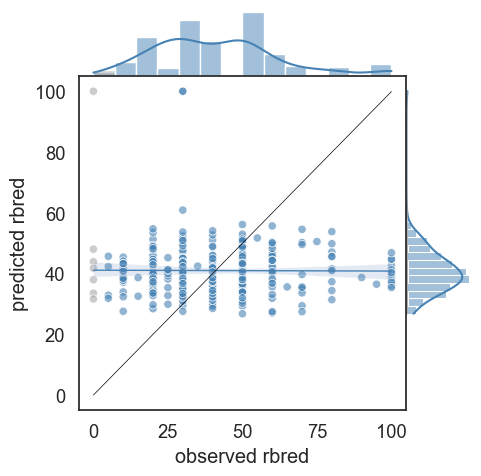

In [32]:
f.plot_observed_predicted(
    residuals_cantho["y_true"], residuals_cantho["y_pred"],  
    hue=residuals_cantho["binary_true_dummy"],
    xlabel=f"observed {target_plot}", ylabel=f"predicted {target_plot}",
    legend=False, #True
    outfile= OUTPATH_FIGURES / f"scatter_obs_pred_{target_plot}_cantho.png"
)       

# plt.xlabel("Model transferability, tested on Can Tho dataset")
# plt.show()

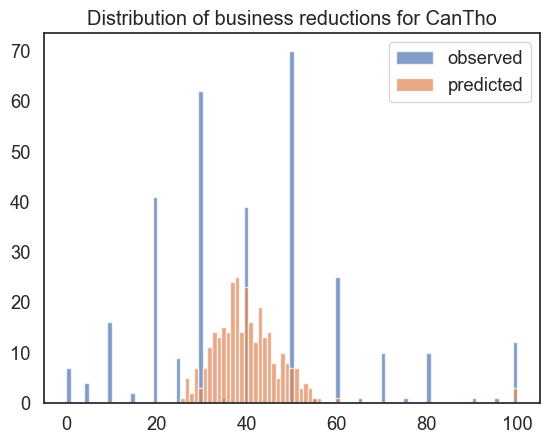

In [33]:
bins = np.linspace(0, 100, 100)

plt.hist((pd.Series(y_true.astype(int))), bins, alpha=0.7, label="observed")
plt.hist((pd.Series(y_pred.astype(int))), bins, alpha=0.7, label="predicted")
plt.legend(loc="upper right")
plt.title("Distribution of business reductions for CanTho")
plt.show()


### Main validation results


In [34]:
## get daamge / total
len(np.where(y_pred>0)[0])
np.mean(y_pred)

41.02096261980831

#### Plot residuals

Text(0, 0.5, 'residuals (prediction - observation)')

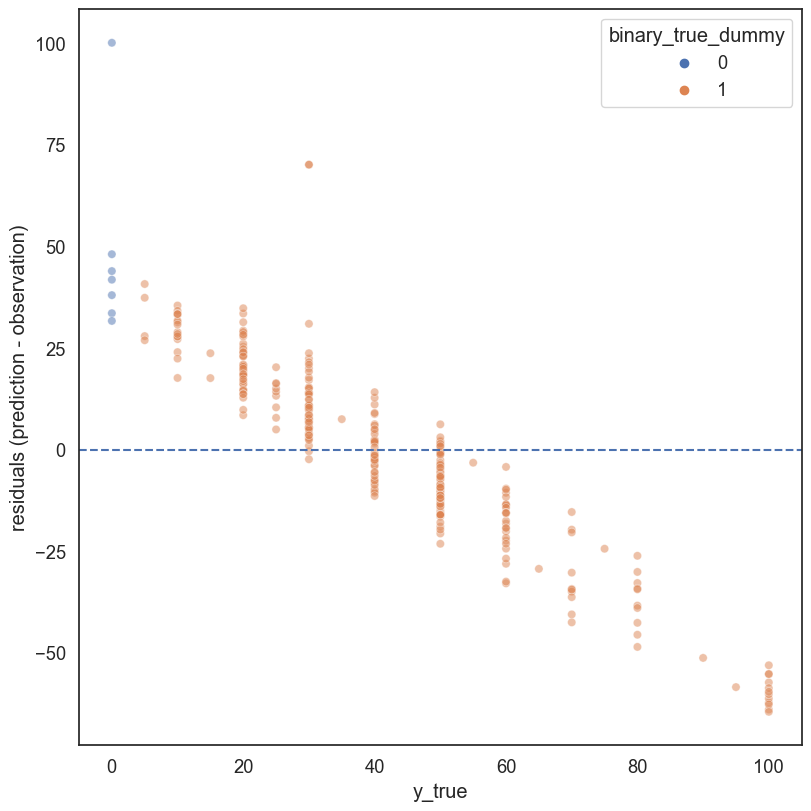

In [35]:
from matplotlib.colors import to_rgba

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

hue_colors=("darkgrey","steelblue")
alpha=0.7

color_dict = {
    0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
    1: to_rgba(hue_colors[1], alpha)
}
ax.axhline(0, ls='--')
sns.scatterplot(
    x = residuals_cantho["y_true"], 
    y = residuals_cantho["residual"], # pred - obs 
    hue = residuals_cantho["binary_true_dummy"],
    alpha = 0.5,

)
plt.ylabel("residuals (prediction - observation)")





### CDFs: Plot prediction bias between HCMC and Can Tho
Cumulative error of predictions for HCMC and Can THo

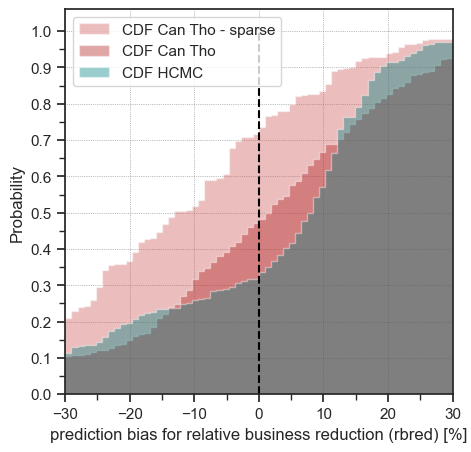

In [36]:
from pylab import *

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : False, "grid.linestyle": ":"}
     )

# fig, ax = plt.subplots(1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(
    [residuals_hcmc["residual"], residuals_cantho["residual"], residuals_cantho_sparse["residual"]],  # pred HCMC+CanTHo rbred
    #bins=bins, 
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    # histtype='step', 
   histtype='stepfilled', alpha=0.4,
    color=("teal","firebrick", "indianred"), 
    label=( "CDF HCMC", "CDF Can Tho",  "CDF Can Tho - sparse"),
) # # bins and (lognormal / normal) datasets are pre-defined

ax.grid( which='major', color='grey', linewidth=0.5)
# ax.grid( which='minor', color='grey', linewidth=0.3)
# ax.set_yticks([-1.25, -0.75, -0.25,0.24,0.75,1.25], minor=True)

## entire CDF
# ## plt.xticks(np.arange(-80, 50, 10))
# plt.xlim(-100, 100)
# plt.xticks(np.arange(-100, 101, 20), minor=False)
# plt.xticks(np.arange(-100, 101, 10), minor=True)
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)
# plt.axvspan(-30, 30, facecolor='grey', alpha=0.3)


## zoomed in
plt.xlim(-30, 30)
plt.xticks(np.arange(-30, 31, 10))
plt.xticks(np.arange(-30, 31, 5), minor=True)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


plt.xlabel("prediction bias for relative business reduction (rbred) [%]")
plt.ylabel("Probability")
plt.legend(loc='best')

plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")

# plt.title("Cumulative distribution functions (CDFs) of prediction bias, normalized")
# plt.savefig(OUTPATH_FIGURES / "cdf_rbred.png", dpi=300, bbox_inches="tight")

plt.savefig(OUTPATH_FIGURES / "cdf_zoomed_rbred.png", dpi=300, bbox_inches="tight")




## Uncertainties in rbred predictions

In [37]:
condition = condition
print("condition: ", condition)
values = df_cantho_bn.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="full")    # type of output data

# print("Inference - Uncertainty distribution: ", pd.Series(F()).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_bn.iloc[:,0].to_numpy()


### avg. uncertainties
dict = {}

for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample

df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: flood cases, rows: sample number 
df_uncertainties.tail(10)


# df_uncertainties_avg = df_uncertainties

df_uncertainties_c_p = pd.DataFrame()
df_uncertainties_c_p["avg_modelled"] = df_uncertainties.mean(axis=0)
df_uncertainties_c_p["observed"] = df_cantho_bn["rbred"]
df_uncertainties_c_p["city"] = "Can Tho"


condition:  [1, 2, 3, 4]


In [38]:
## uncertainties for sparse BN

values = df_cantho_bn.iloc[:,[2, 3, 4]].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference([2, 3, 4],        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="full")    # type of output data
              #Output="median")    # type of output data


## inference of node for water depth and node for target
F_water = [row[0] for row in F]
F_target = [row[1] for row in F]
print("Inference - Uncertainty distribution: ", pd.Series(F_target).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F_target
y_true = df_cantho_bn.iloc[:,0].to_numpy()


dict = {}
for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample

df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: flood cases, rows: sample number 
df_uncertainties.tail(10)

# df_uncertainties_avg = df_uncertainties

df_uncertainties_c_sparse_p = pd.DataFrame()
df_uncertainties_c_sparse_p["avg_modelled"] = df_uncertainties.mean(axis=0)
df_uncertainties_c_sparse_p["observed"] = df_cantho_bn["rbred"]
df_uncertainties_c_sparse_p["city"] = "Can Tho - sparse"


Inference - Uncertainty distribution:  count                                                   313
unique                                                  313
top       [30.0, 20.0, 20.0, 20.0, 10.0, 40.0, 25.0, 50....
freq                                                      1
dtype: object


In [39]:
## join uncertainites from BNs for hcmc, cantho, and cantho-sparse 

df_uncertainties_hc_sparse_p = pd.concat([df_uncertainties_p, df_uncertainties_c_p, df_uncertainties_c_sparse_p], axis=0)
df_uncertainties_hc_sparse_p
# df_uncertainties_hc_p = pd.melt(df_uncertainties_hc_p, id_vars=['city'], var_name=['city'])
print(df_uncertainties_hc_sparse_p)


     avg_modelled  observed              city
0         13.2593         0              HCMC
1         16.1688         0              HCMC
2          8.8827         0              HCMC
3         11.7655         0              HCMC
4          9.5583         0              HCMC
..            ...       ...               ...
308       12.0757       100  Can Tho - sparse
309       20.5088        30  Can Tho - sparse
310       20.0595       100  Can Tho - sparse
311       15.8502        50  Can Tho - sparse
312       17.8761        50  Can Tho - sparse

[987 rows x 3 columns]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


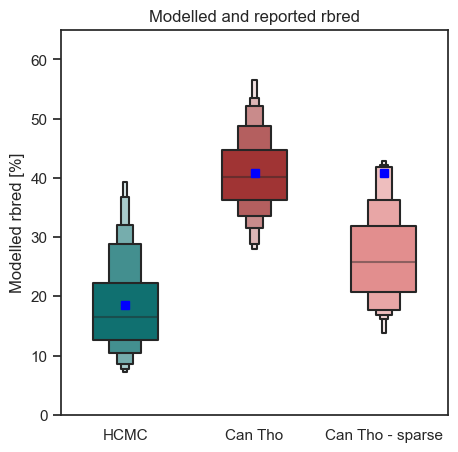

In [40]:
group = "city"
column = "avg_modelled"
scatterpoints="observed"


grouped = df_uncertainties_hc_sparse_p.groupby(group)
categories = np.unique(df_uncertainties_hc_sparse_p[scatterpoints])
colors = np.linspace(0, 1, len(categories))


names, vals, xs, colrs = [], [] ,[], []

for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
    colrs.append(subdf[scatterpoints].tolist())

# fig = plt.figure()
# ax = fig.add_subplot(111)
fig, ax = plt.subplots(figsize=(5, 5))
fig.canvas.draw()


## average predicted means
p = sns.boxenplot(
    x = df_uncertainties_hc_sparse_p["city"],
    y = df_uncertainties_hc_sparse_p["avg_modelled"],
    width=.5,
    showfliers=False,
    # showmeans=True,
    palette=["teal", "firebrick", "lightcoral"],
    line_kws={"linewidth":1.5},# color":"cde"
    flier_kws={"facecolor":.7, "linewidth":.5},
)

# observed mean
sns.boxplot(
    x = df_uncertainties_hc_sparse_p["city"],
    y = df_uncertainties_hc_sparse_p["observed"],
    # labels="HCMC",
    showfliers=False,
    showmeans=True,
    medianprops={"color": "r", "linewidth": 0, "alpha":0.0},
    boxprops={"facecolor":"steelblue", "alpha":0.0},
    whiskerprops={"color":"k", "alpha":0.},
    capprops={"color":"k", "alpha":0},
    meanprops={"marker":"s", "markerfacecolor":"blue", "markeredgecolor":"blue"}
)

p.tick_params(bottom=False)  # remove x ticks
plt.legend().set_visible(False)  # surpress legend

plt.ylim(0, 65)
plt.ylabel(f"Modelled {target} [%]")
plt.xlabel(f"")
plt.title("Modelled and reported rbred")
plt.savefig(OUTPATH_FIGURES / f"uncertainties_{target}.png", dpi=300, bbox_inches="tight")


## Absolute business interruption

**NOTE !**
Unlike as for the HCMC survey the question to business interruption refers to the decrease in revenues over the entire month

- 3.40.	How much was monthly sale of your shop in the month it had flood: 
    Monthly sale decreases ……….. % in comparison with monthly average sale\\
Thus, the absolute costs are calculated directly with the monthly averge sale (differently than for HCMC)


In [41]:
# assert (df_hcmc[target].values == df_hcmc_bn[target].values == residuals_hcmc["y_true"].values),
assert all(df_cantho[target].tail(29).values ==  residuals_cantho["y_true"].tail(29).values),  "fix code were y_true is shuffled - residual df should have the same order as when it was loaded"

## TODO fix workaround that each record is used once for validation, currently 356 records and with 5 folds one sample has to been drop 
#df_cantho = df_cantho[:-1]  # drop last record which is not caputred by 

assert all(df_cantho[target].tail(29).values ==  residuals_cantho["y_true"].tail(29).values),  "fix code were y_true is shuffled - residual df should have the same order as when it was loaded"
assert all(df_cantho_bn[target].tail(29).values ==  residuals_cantho["y_true"].tail(29).values),  "fix code were y_true is shuffled - residual df should have the same order as when it was loaded"


In [42]:
##  get first abs loss of only damage cases (only BN results) due that rcloss cases are all multiplied by chance of loss
df_cantho_abred = df_cantho.copy()

## calc probability obs. abs bred
df_cantho_abred["abred"] = np.nan
# df_hcmc_abred["abred"] = df_hcmc_abred[target] * df_hcmc["mthly. sales"] / 100
df_cantho_abred = df_cantho.assign(abred = lambda x: (x[target]/100 * x["mthly. sales"]))

## make sure that order of records is identical between BN predictions and osberved rbred
assert all(df_cantho_abred["rbred"].reset_index(drop=True) == residuals_cantho.y_true.reset_index(drop=True))

## calc probability pred. abs bred
df_cantho_abred["pred_abred"] = np.nan
df_cantho_abred["pred_rbred"] = residuals_cantho["y_pred"]
df_cantho_abred = df_cantho_abred.assign(pred_abred = lambda x: (residuals_cantho["y_pred"].reset_index(drop=True)/100 * x["mthly. sales"].reset_index(drop=True)))
# df_hcmc_abred["abred_pred"] = residuals_hcmc["y_pred"].reset_index(drop=True) *  df_hcmc["mthly. sales"].reset_index(drop=True)  / 100 
# df_hcmc_abred["abred_pred"] = df_hcmc_abred[pred_target] *  df_hcmc_abred["mthly. sales"] / 100 



# ## calc probably obs. abs bred
# df_cantho_abred["abred_true"] = df_cantho_abred[target] * df_cantho["mthly. sales"] / 100
# # df_hcmc_abred["abred_true"] = residuals_hcmc["y_true"] * df_hcmc["mthly. sales"] / 100

# ## calc probably pred. abs bred
# df_cantho_abred["abred_pred"] = residuals_cantho["y_pred"].reset_index(drop=True) *  df_cantho["mthly. sales"].reset_index(drop=True)  / 100 
# # df_hcmc_abred["abred_pred"] = df_hcmc_abred[pred_target] *  df_hcmc_abred["mthly. sales"] / 100 


## add binary dummy var for plotting zero-damage vs damage cases
df_cantho_abred["binary_true_dummy"] = 0
idx_damage = np.where(residuals_cantho["y_true"] >= 1)[0]
df_cantho_abred.loc[idx_damage, "binary_true_dummy"] = 1

df_cantho_abred

# ## rm mising obsvation
# df_cantho_abred.dropna(inplace=True)

# print("HCMC : absolute business interruption (zero-cases and damage cases)")
# eu.empirical_vs_predicted(df_cantho_abred["abred_true"], df_cantho_abred["abred_pred"])


,rbred,inundation duration,water depth inside,contaminations,flow velocity,flood experience,building age,building area,shp_sector,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,shp_content_value_euro,mthly. sales,abred,pred_abred,pred_rbred,binary_true_dummy
0,40,3.0,40,1,0.4,76,16.0,60.0,2,149.6,0.444444,1,0.00,0.000000,5,80.1625,855.0,342.00,395.182710,46.2202,1
1,50,3.0,30,1,0.5,76,26.0,31.5,4,320.6,0.444444,3,0.25,0.333333,1,3740.6500,641.3,320.65,303.947341,47.3955,1
2,50,3.0,20,1,0.4,76,16.0,20.0,2,320.6,0.444444,1,0.50,0.333333,5,40.0750,641.3,320.65,263.319063,41.0602,1
3,50,4.0,40,1,0.3,76,16.0,49.0,2,149.6,0.222222,2,0.50,0.000000,4,801.5500,128.3,64.15,52.391177,40.8349,1
4,10,1.0,20,0,0.3,8,8.0,100.0,1,320.6,0.222222,1,0.75,0.333333,1,4007.8375,64.1,6.41,23.825970,37.1700,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,100,5.0,60,0,0.1,8,26.0,140.0,1,320.6,0.555556,1,0.50,0.333333,2,1603.1250,299.3,299.30,106.085987,35.4447,1
309,30,2.0,20,1,0.3,8,16.0,184.0,1,149.6,0.444444,1,0.50,0.333333,3,374.0750,85.6,25.68,31.444646,36.7344,1
310,100,4.0,60,1,0.3,16,26.0,60.0,5,149.6,0.111111,3,0.50,0.333333,1,374.0750,NaN,NaN,NaN,40.3746,1
311,50,3.0,20,1,0.3,8,26.0,150.0,2,320.6,0.444444,4,0.50,0.666667,1,1603.1250,1710.0,855.00,547.783110,32.0341,1


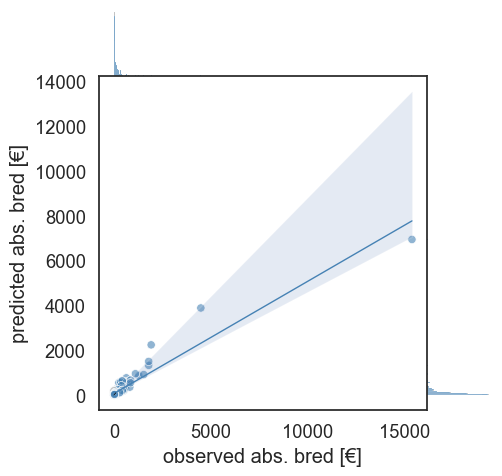

In [43]:
## TODO adapt x and y aixs to same limits -> use fixed max for xlim and ylim 
## TDO fix hue  all zero should be vertical  test mit =df_cantho_pred_cd["abred_true"]as binary
plot_observed_predicted_abs(
    y_true=df_cantho_abred["abred"], y_pred=df_cantho_abred["pred_abred"], 
    hue=df_cantho_abred["binary_true_dummy"],
    # hue_colors=("darkgrey","steelblue"),
    xlabel=f"observed abs. bred [€]", ylabel=f"predicted abs. bred [€]",
    legend=False , #True
    outfile= OUTPATH_FIGURES / f"scatter_obs_pred_abs_bred_{target_plot}_cantho.png"
)     


## Abs. degree of bred (only damage cases of busienss interruption) ~ Income 

compare degree of bred in monetary terms with income levels, in the view to better compare the findings with the results from Chinh 2016 for SMEs in Can Tho

In [44]:
df_hcmc_income = df_hcmc_abred.loc[df_hcmc_abred["abred"]>0.0, ["abred", "rbred", "mthly. income", "mthly. sales"]]
df_hcmc_income["rloss_income"] = df_hcmc_income["abred"] / df_hcmc_income["mthly. income"] * 100
df_hcmc_income.describe()

,abred,rbred,mthly. income,mthly. sales,rloss_income
count,115.000000,115.000000,115.000000,115.000000,115.000000
mean,73.912037,32.773913,454.398261,418.702609,16.162562
std,159.037412,28.353366,329.511000,500.725306,36.402208
min,0.030700,1.000000,110.500000,92.100000,0.010421
25%,1.841667,10.000000,294.600000,92.100000,0.590392
50%,7.365000,20.000000,294.600000,276.200000,1.666667
75%,31.154667,50.000000,552.400000,736.500000,13.051316
max,736.500000,100.000000,2393.700000,2761.900000,218.759900


In [45]:
print("Number of businesses which experienced interruption exceeds brutto monthly income :", df_hcmc_income[df_hcmc_income["rloss_income"]> 100].shape[0])
df_hcmc_income[df_hcmc_income["rloss_income"]> 100].tail(4)

Number of businesses which experienced interruption exceeds brutto monthly income : 5


,abred,rbred,mthly. income,mthly. sales,rloss_income
156,589.200000,80,552.4,736.5,106.661839
158,368.266667,100,294.6,276.2,125.005657
240,644.466667,100,294.6,276.2,218.759900
327,589.200000,80,552.4,736.5,106.661839


In [46]:
df_cantho_abred.describe()

,rbred,inundation duration,water depth inside,contaminations,flow velocity,flood experience,building age,building area,shp_sector,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,shp_content_value_euro,mthly. sales,abred,pred_abred,pred_rbred,binary_true_dummy
count,313.000000,313.000000,313.000000,313.000000,310.000000,313.000000,297.000000,310.000000,313.000000,312.000000,313.000000,313.000000,313.000000,313.000000,313.000000,312.000000,287.000000,287.000000,287.000000,313.000000,313.000000
mean,40.862620,4.325879,26.431310,0.722045,0.359677,42.226837,28.952862,96.524516,2.594249,268.916346,0.294285,1.680511,0.295527,0.226837,2.747604,1263.994244,475.681533,218.531568,174.174228,41.020963,0.977636
std,21.850827,3.407552,16.068241,0.469649,0.109219,33.201352,14.145640,166.770178,1.655865,283.957268,0.189272,1.216936,0.251844,0.206769,1.616284,2857.550241,1688.906299,970.740331,509.811103,8.606050,0.148102
min,0.000000,1.000000,0.000000,0.000000,0.100000,3.000000,8.000000,9.000000,1.000000,10.700000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.800000,0.000000,5.186547,26.798500,0.000000
25%,25.000000,2.000000,15.000000,0.000000,0.300000,8.000000,16.000000,40.000000,1.000000,149.600000,0.111111,1.000000,0.000000,0.000000,1.000000,160.325000,85.600000,25.660000,36.275226,36.005200,1.000000
50%,40.000000,4.000000,20.000000,1.000000,0.400000,36.000000,26.000000,65.500000,2.000000,149.600000,0.333333,1.000000,0.250000,0.333333,2.000000,400.775000,171.000000,64.140000,70.066683,40.279800,1.000000
75%,50.000000,6.000000,40.000000,1.000000,0.400000,76.000000,36.000000,100.000000,4.000000,320.600000,0.444444,2.000000,0.500000,0.333333,4.000000,1246.883333,384.700000,153.890000,139.110128,44.705100,1.000000
max,100.000000,24.000000,80.000000,2.000000,0.500000,76.000000,61.000000,2000.000000,6.000000,2137.500000,0.888889,8.000000,1.000000,0.666667,6.000000,37406.450000,25650.200000,15390.120000,6941.790577,100.100000,1.000000


In [47]:
df_cantho_income = df_cantho_abred.loc[df_cantho_abred["abred"]>0.0, ["abred", "rbred", "mthly. income","mthly. sales"]]
df_cantho_income["rloss_income"] = df_cantho_income["abred"] / df_cantho_income["mthly. income"] * 100
df_cantho_income.describe()


,abred,rbred,mthly. income,mthly. sales,rloss_income
count,280.000000,280.000000,280.000000,280.000000,280.000000
mean,223.994857,42.107143,257.243929,482.671071,78.078494
std,982.217651,20.860244,269.616869,1709.210916,135.754710
min,1.285000,5.000000,10.700000,12.800000,0.858957
25%,25.680000,30.000000,149.600000,85.600000,17.152406
50%,64.150000,40.000000,149.600000,171.000000,34.304813
75%,170.970000,50.000000,320.600000,384.700000,80.006238
max,15390.120000,100.000000,2137.500000,25650.200000,1028.743316


In [48]:
print("Number of buisnesses for which business interruption loss exceeds brutto monhtly income :", df_cantho_income[df_cantho_income["rloss_income"]> 100].shape[0])
df_cantho_income[df_cantho_income["rloss_income"]> 100].tail(4)  # 19% severe abred > income

Number of buisnesses for which business interruption loss exceeds brutto monhtly income : 53


,abred,rbred,mthly. income,mthly. sales,rloss_income
293,64.15,50,64.1,128.3,100.078003
300,342.00,100,320.6,342.0,106.674984
306,427.60,100,149.6,427.6,285.828877
311,855.00,50,320.6,1710.0,266.687461


#### Chinh results for Can Tho (incl also SMEs)

In [49]:
## get reported content losses in CHinh 2016 from USD [2011] to Euro [2020]

# # GDP deflator source : https://jp.tradingeconomics.com/united-states/gdp-deflator
gdp_price_index_2011 = 91.48  # 2011  #  chinh 2016 uses 2011 as reference year
gdp_price_index_2020 = 105.37 # price level 2020 based on GDP-deflation

# for r in range(len(vars_money.Target_contentloss_VND)):
chinh16_results = pd.DataFrame({
    ## degree of rcloss (only damage cases)
    # "mean_degree_closs_usd": [98], # price level 2011 in USD
    # "median_degree_closs_usd": [10] ,# price level 2011 in USD
    ## bred (only damage c-ases)
    "mean_degree_closs_usd": [3935], # price level 2011 in USD
    "median_degree_closs_usd": [207] ,# price level 2011 in USD
    "mean_degree_closs_euro": [None],
    "median_degree_closs_euro": [None],
})
for r in range(len(chinh16_results.mean_degree_closs_usd)):
    chinh16_results["mean_degree_closs_euro"][r] = round(chinh16_results["mean_degree_closs_usd"][r] * gdp_price_index_2020 / gdp_price_index_2011, 1)  # price level 2020 in Euro
    chinh16_results["median_degree_closs_euro"][r] = round(chinh16_results["median_degree_closs_usd"][r] * gdp_price_index_2020 / gdp_price_index_2011, 1)  # price level 2020 in Euro

chinh16_results

,mean_degree_closs_usd,median_degree_closs_usd,mean_degree_closs_euro,median_degree_closs_euro
0,3935,207,4532.5,238.4


### Plot prediction bias between HCMC and Can Tho
Cumulative error of predictions for HCMC and Can THo

In [50]:
## creaate residuals of abs. pred.
df_hcmc_abred["residual"] = df_hcmc_abred["pred_abred"] - df_hcmc_abred["abred"]
df_cantho_abred["residual"] = df_cantho_abred["pred_abred"] - df_cantho_abred["abred"]

df_cantho_abred.sort_values("residual")
## create reisduals for rel. pred for  cantho
# df_cantho_pred_cd["residual"] = df_cantho_pred_cd[pred_target] - df_cantho_pred_cd[target]

,rbred,inundation duration,water depth inside,contaminations,flow velocity,flood experience,building age,building area,shp_sector,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,shp_content_value_euro,mthly. sales,abred,pred_abred,pred_rbred,binary_true_dummy,residual
193,60,5.0,10,1,0.2,8,8.0,75.0,4,2137.5,0.444444,3,0.00,0.666667,1,1246.883333,25650.2,15390.12,6941.790577,27.0633,1,-8448.329423
79,60,3.0,10,1,0.4,76,26.0,42.5,6,149.6,0.444444,2,0.50,0.333333,5,374.075000,2565.0,1539.00,913.257990,35.6046,1,-625.742010
164,50,3.0,40,0,0.4,8,26.0,52.0,1,641.3,0.111111,1,0.00,0.333333,2,1603.125000,8977.6,4488.80,3885.514258,43.2801,1,-603.285742
200,60,5.0,20,1,0.5,8,16.0,64.0,3,2137.5,0.000000,5,0.50,0.000000,2,5343.775000,2992.5,1795.50,1325.390220,44.2904,1,-470.109780
253,80,1.0,20,0,0.2,8,36.0,24.0,1,320.6,0.222222,1,0.00,0.333333,1,4007.837500,1026.0,820.80,353.044548,34.4098,1,-467.755452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,30,5.0,10,0,0.2,8,26.0,160.0,2,NaN,0.000000,7,0.00,0.333333,1,12468.816667,NaN,NaN,NaN,27.5981,1,NaN
245,20,4.0,10,1,0.3,76,36.0,120.0,3,641.3,0.666667,2,0.00,0.333333,1,1246.883333,NaN,NaN,NaN,32.7443,1,NaN
246,20,3.0,5,1,0.4,8,26.0,48.0,4,2137.5,0.333333,4,0.00,0.333333,2,2671.891667,NaN,NaN,NaN,33.5995,1,NaN
284,50,8.0,20,1,0.3,76,36.0,60.0,6,641.3,0.333333,1,0.25,0.000000,1,801.550000,NaN,NaN,NaN,38.6948,1,NaN


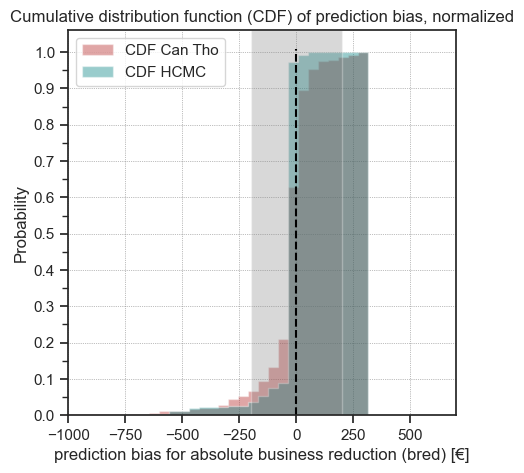

In [51]:
from pylab import *

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : False, "grid.linestyle": ":"}
     )

# fig, ax = plt.subplots(1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(
    [df_hcmc_abred["residual"], df_cantho_abred["residual"]],  # pred abs bred
    #bins=bins, 
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    # histtype='step', 
    histtype='stepfilled', alpha=0.4,
    color=("teal","firebrick"), 
    label=("CDF HCMC", "CDF Can Tho"),
) # # bins and (lognormal / normal) datasets are pre-defined

ax.grid( which='major', color='grey', linewidth=0.5)
# ax.grid( which='minor', color='grey', linewidth=0.3)
# ax.set_yticks([-1.25, -0.75, -0.25,0.24,0.75,1.25], minor=True)


# plt.xticks(np.arange(-80, 50, 10))
plt.xlim(-1000, 700)
plt.xticks(np.arange(-1000, 701, 500), minor=True)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)
plt.axvspan(-200, 200, facecolor='grey', alpha=0.3)

# ## zoomed in
# plt.xlim(-200, 200)
# plt.xticks(np.arange(-200, 201, 100))
# plt.xticks(np.arange(-200, 201, 50), minor=True)
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


plt.xlabel("prediction bias for absolute business reduction (bred) [€]")
plt.ylabel("Probability")
plt.title("Cumulative distribution function (CDF) of prediction bias, normalized")
plt.legend(loc='best')

plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")


plt.savefig(OUTPATH_FIGURES / "cdf_abred.png", dpi=300, bbox_inches="tight")
#plt.savefig(OUTPATH_FIGURES / "cdf_zoomed_abred.png", dpi=300, bbox_inches="tight")




In [52]:
bins

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

In [53]:
OUTPATH_FIGURES

WindowsPath('../model_results/bayesian_network')

## Distirbutions Bred for CanTho and HCMC

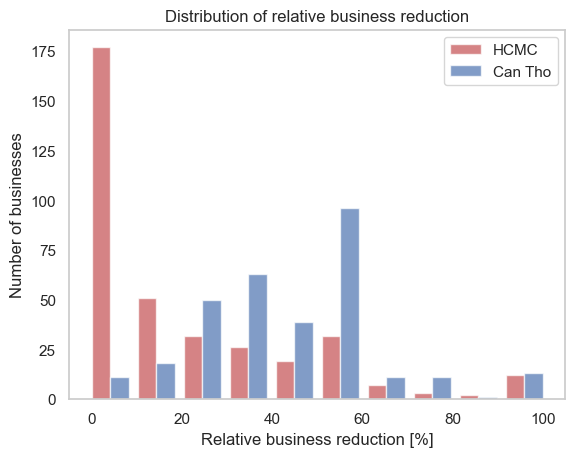

In [54]:
#bins = np.linspace(0, 100, 100)
#plt.hist(df_hcmc_bn["rbred"], bins, alpha=0.7, label="HCMC")
#plt.hist(df_cantho["rbred"], bins, alpha=0.7, label="Can Tho")

import seaborn as sns

# sns.set_theme()  # <-- This actually changes the look of plots.
sns.set_style("whitegrid", {"axes.grid" : False})
fig, ax = plt.subplots()
plt.hist(
    [
        df_hcmc_bn["rbred"], 
        df_cantho_bn["rbred"]
    ], 
    color=["r","b"], alpha=0.7,  
    label=["HCMC", "Can Tho"],
    # bins=range(-1, 101, 10)
    bins = np.linspace(-1, 101, 11)
)

# TODO make to 10 bins with equal ranges

plt.legend(loc="upper right")
plt.xlabel("Relative business reduction [%]")
plt.ylabel("Number of businesses")
plt.title("Distribution of relative business reduction")# (source: survey datasets)
plt.show()

In [55]:
df_hcmc

,rbred,emergency measures,water depth inside,resilience,no. employees,building age,mthly. income,inundation duration,non-structural measures,contaminations,structural measures,mthly. sales,flood experience,building area,flow velocity,shp_business_limitation,shp_content_value_euro,shp_sector
0,0,0.000000,10.0,5.00,1,12.0,110.5,2.0,0.00,0,0.0,276.2,76,25.0,0.2,0.0,441.9,1.0
1,0,0.000000,15.0,5.00,1,0.0,294.6,2.0,0.00,1,0.0,276.2,76,21.0,0.2,0.0,441.9,2.0
2,0,0.000000,2.0,3.50,1,21.0,552.4,1.0,0.75,0,0.5,92.1,76,50.0,0.2,0.0,4124.5,3.0
3,0,0.000000,5.0,4.00,1,20.0,294.6,3.0,0.25,1,0.5,92.1,16,80.0,0.3,0.0,4124.5,1.0
4,0,0.000000,3.0,3.50,1,20.0,552.4,0.5,0.50,0,0.5,276.2,3,55.0,0.2,0.0,3682.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,20,0.833333,60.0,3.75,2,33.0,110.5,4.0,1.00,1,0.0,92.1,151,150.0,0.3,1.0,4124.5,1.0
356,30,0.666667,40.0,3.25,1,15.0,110.5,2.0,0.75,1,0.0,92.1,76,80.0,0.3,2.0,6886.4,1.0
357,30,0.666667,40.0,2.00,2,1.0,294.6,5.0,0.50,1,0.0,276.2,151,80.0,0.2,1.0,4603.2,1.0
358,10,0.833333,60.0,1.00,2,30.0,552.4,4.0,0.75,1,0.0,736.5,151,60.0,0.3,0.0,3203.8,1.0


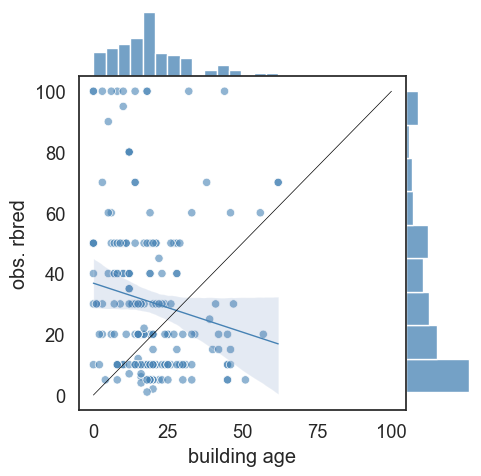

In [56]:
## building age ~ bred

tt = df_hcmc.loc[df_hcmc[target]>0 , :]
## binary var for obs bred (zero-loss-case and damage-case)
tt["obs_binary_bred"] = 0
tt.loc[tt[target]>0, "obs_binary_bred"]  = 1

plot_observed_predicted_abs(
    #y_true=df_hcmc_d["building age"], y_pred=df_hcmc_d[target], 
    y_true=tt["building age"], y_pred=tt[target], 
    #hue=df_hcmc_pred_cd["building age"],
    hue=tt["obs_binary_bred"],
    xlabel=f"building age", ylabel=f"obs. rbred",
    legend=False ,#True
    outfile= OUTPATH_FIGURES / f"scatter_test_building age_bred_hcmc.png"
)     



In [57]:
print(df_hcmc_bn["rbred"].value_counts())
df_cantho_bn["rbred"].value_counts()

rbred
0      149
10      45
20      29
30      24
50      24
5       22
40      18
100     11
60       8
70       7
15       5
80       3
25       2
7        2
35       2
90       2
45       1
12       1
6        1
2        1
1        1
22       1
95       1
4        1
Name: count, dtype: int64


rbred
50     70
30     62
20     41
40     39
60     25
10     16
100    12
80     10
70     10
25      9
0       7
5       4
15      2
35      1
95      1
55      1
90      1
65      1
75      1
Name: count, dtype: int64